# Running a new test for Dr. Masters' questions

## loading some complete new data

In [20]:
## loading models
from joblib import dump, load
import sklearn
import numpy as np 
import pandas as pd
import talib as ta
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

## load all the helper functions written in scipt stats_check
from stats_check import *

import warnings
warnings.filterwarnings("ignore")


In [23]:
df = pd.read_csv('OEX_complete_new.csv')
df['Date'] = pd.to_datetime(df['Date'], format = '%Y%m%d')

print(min(df.Date), max(df.Date))
print(df.shape)

2020-01-09 00:00:00 2023-01-06 00:00:00
(755, 24)


In [25]:
df = df[df['Date'] >= datetime(2022, 1, 9)]
print(min(df.Date), max(df.Date))


2022-01-10 00:00:00 2023-01-06 00:00:00


In [26]:
ticker_name = 'OEX'
indicator_name = 'PR_INT_0'
model_name = 'gb'
model = load(f'../../model_joblib/{ticker_name}_{model_name}_{indicator_name}.joblib') 
base_model = load(f'../../model_joblib/{ticker_name}_{model_name}_base.joblib') 

df = df.set_index('Date')
for n in list(range(1,15)):
    name = 'ret' + str(n)
    df[name] = df['Open'].pct_change(periods=n)#for trading with open

df['retFut1'] = df['Open'].pct_change(1).shift(-1).fillna(0)
base_col = ['ret1', 'ret2', 'ret3', 'ret4', 'ret5', 'ret6', 'ret7', 'ret8', 'ret9',
    'ret10', 'ret11', 'ret12', 'ret13', 'ret14']


In [27]:
X = df.drop(['retFut1'], axis=1)
y = df[['retFut1']]


X['pred_ret'] = model.predict(X[base_col + [indicator_name]])
X['true_ret'] = y
X['pred_ret_base'] = base_model.predict(X[base_col])
print('spearmanr for model with indicator is:', information_coefficient(y,X['pred_ret'] ))
print('spearmanr for model without indicator is:', information_coefficient(y, X['pred_ret_base']))


X['pred_cumret_ind_fractional'] = np.cumprod( ((X['pred_ret'] * X['true_ret']) ) + 1)  - 1
X['pred_cumret_base_fractional'] = np.cumprod( ((X['pred_ret_base'] * X['true_ret']) ) + 1)  - 1


base_positions = np.where(X['pred_ret_base']> 0,1,-1 ) #POSITIONS
base_dailyRet = pd.Series(base_positions).fillna(0).values * X['true_ret'] #for trading right after the open
base_cumret = np.cumprod(base_dailyRet + 1) - 1

ind_positions = np.where(X['pred_ret']> 0,1,-1 ) #POSITIONS
ind_dailyRet = pd.Series(ind_positions).fillna(0).values * X['true_ret'] #for trading right after the open
ind_cumret = np.cumprod(ind_dailyRet + 1) - 1

X['pred_cumret_ind_positional'] = ind_cumret
X['pred_cumret_base_positional'] = base_cumret


spearmanr for model with indicator is: 0.8151985791772668
spearmanr for model without indicator is: 0.028320069121105938


spearmanr for model with indicator is: 0.8151985791772668
spearmanr for model without indicator is: 0.028320069121105938


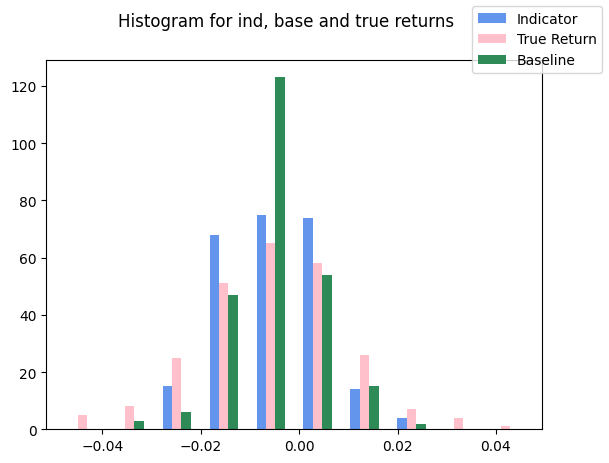

In [37]:
fig, ax = plt.subplots()

b_heights, b_bins = np.histogram(X['true_ret'])

a_heights, a_bins = np.histogram(X['pred_ret'], bins=b_bins)
c_heights, c_bins = np.histogram(X['pred_ret_base'], bins = b_bins)

width = (b_bins[1] - b_bins[0])/5

ax.bar(a_bins[:-1]-width, a_heights, width=width, facecolor='cornflowerblue', label = 'Indicator')
ax.bar(b_bins[:-1], b_heights, width=width, facecolor='pink', label = 'True Return')
ax.bar(c_bins[:-1]+width, c_heights, width=width, facecolor='seagreen', label = 'Baseline')
fig.legend()
fig.suptitle('Histogram for ind, base and true returns')
print('spearmanr for model with indicator is:', information_coefficient(y,X['pred_ret'] ))
print('spearmanr for model without indicator is:', information_coefficient(y, X['pred_ret_base']))

No handles with labels found to put in legend.


Text(0.5, 0.98, 'OEX Equity Curve (Return) with PR_INT_0')

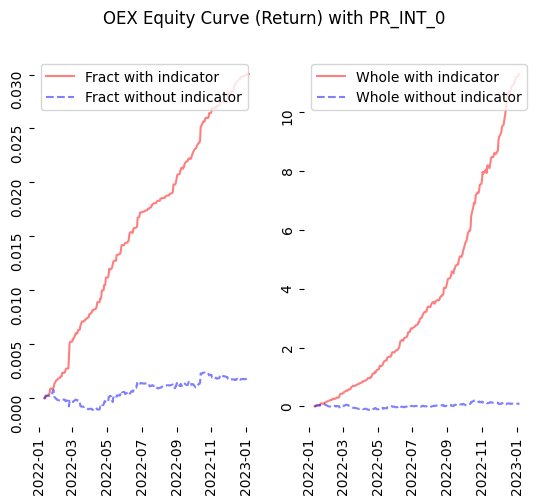

In [35]:
fig, (ax1,ax2) = plt.subplots(ncols=2,  subplot_kw=dict(frameon=False)) 

plt.subplots_adjust(hspace=.0)
plt.legend()

ax1.plot(X.index, X['pred_cumret_ind_fractional'], label = "Fract with indicator", linestyle="-", color = 'red',alpha = 0.5)
ax1.plot(X.index, X['pred_cumret_base_fractional'], label = "Fract without indicator", linestyle="--", color = 'blue', alpha = 0.5)
ax2.plot(X.index, X['pred_cumret_ind_positional'], label = "Whole with indicator", linestyle="-", color = 'red',alpha = 0.5)
ax2.plot(X.index, X['pred_cumret_base_positional'], label = "Whole without indicator", linestyle="--", color = 'blue', alpha = 0.5)
ax1.tick_params(labelrotation=90)
ax2.tick_params(labelrotation=90)
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

plt.suptitle(f'{ticker_name} Equity Curve (Return) with {indicator_name}')


# Constructing the Equity Curve

This notebook is written to construct the equity curve using the model we just built from notebook 'model_with_shap_instruction.ipynb'

It would require {ticker_name}_full.csv files, multiple models joblib files, which carry the models we trained from previous notebook.

In [57]:

train_size = 0.75
no_rows = df.shape[0]
train_size = int(no_rows * train_size)
train, test = df[0:train_size], df[train_size: no_rows]
X_train = train.drop(['retFut1'], axis=1)
y_train = train[['retFut1']]
X_test = test.drop(['retFut1'], axis=1)
y_test = test[['retFut1']]

cagr, ratio, cagr_ratio = extra_model_eva(model, X_test[base_col + [indicator_name]], y_test)
print('the model with indicator has CAGR', cagr)

cagr_base, ratio, cagr_ratio = extra_model_eva(base_model, X_test[base_col], y_test)
print('the model without indicator has CAGR', cagr_base)

X_test_res = X_test.copy()
X_test_res['true_open'] = df['Open'][train_size: no_rows]


X_test_res['pred_ret'] = model.predict(X_test[base_col + [indicator_name]])
X_test_res['true_ret'] = y_test
X_test_res['pred_ret_base'] = base_model.predict(X_test[base_col])
print('spearmanr for model with indicator is:', information_coefficient(y_test,X_test_res['pred_ret'] ))
print('spearmanr for model without indicator is:', information_coefficient(y_test, X_test_res['pred_ret_base']))


X_test_res['pred_cumret_ind_fractional'] = np.cumprod( ((X_test_res['pred_ret'] * X_test_res['true_ret']) ) + 1)  - 1
X_test_res['pred_cumret_base_fractional'] = np.cumprod( ((X_test_res['pred_ret_base'] * X_test_res['true_ret']) ) + 1)  - 1


base_positions = np.where(X_test_res['pred_ret_base']> 0,1,-1 ) #POSITIONS
base_dailyRet = pd.Series(base_positions).fillna(0).values * X_test_res['true_ret'] #for trading right after the open
base_cumret = np.cumprod(base_dailyRet + 1) - 1

ind_positions = np.where(X_test_res['pred_ret']> 0,1,-1 ) #POSITIONS
ind_dailyRet = pd.Series(ind_positions).fillna(0).values * X_test_res['true_ret'] #for trading right after the open
ind_cumret = np.cumprod(ind_dailyRet + 1) - 1

X_test_res['pred_cumret_ind_positional'] = ind_cumret
X_test_res['pred_cumret_base_positional'] = base_cumret


the model with indicator has CAGR 3.4906313944255016
the model without indicator has CAGR 0.10053412982757681
spearmanr for model with indicator is: 0.7728171461398647
spearmanr for model without indicator is: 0.025656027120504365


spearmanr for model with indicator is: 0.7728171461398647
spearmanr for model without indicator is: 0.025656027120504365


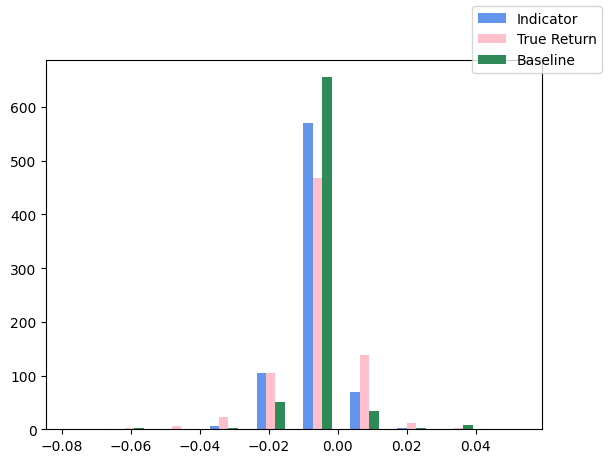

In [58]:
fig, ax = plt.subplots()

b_heights, b_bins = np.histogram(X_test_res['true_ret'])

a_heights, a_bins = np.histogram(X_test_res['pred_ret'], bins=b_bins)
c_heights, c_bins = np.histogram(X_test_res['pred_ret_base'], bins = b_bins)

width = (b_bins[1] - b_bins[0])/5

ax.bar(a_bins[:-1]-width, a_heights, width=width, facecolor='cornflowerblue', label = 'Indicator')
ax.bar(b_bins[:-1], b_heights, width=width, facecolor='pink', label = 'True Return')
ax.bar(c_bins[:-1]+width, c_heights, width=width, facecolor='seagreen', label = 'Baseline')
fig.legend()
print('spearmanr for model with indicator is:', information_coefficient(y_test,X_test_res['pred_ret'] ))
print('spearmanr for model without indicator is:', information_coefficient(y_test, X_test_res['pred_ret_base']))

Text(0.5, 0.98, 'OEX Returns(actual, predicted) with PR_INT_0')

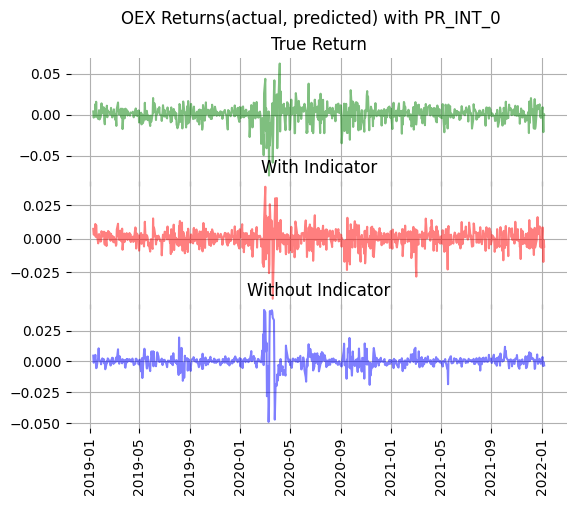

In [27]:

fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=True, subplot_kw=dict(frameon=False)) 

plt.subplots_adjust(hspace=.0)

plt.xticks(rotation=90)
ax1.grid()
ax2.grid()
ax3.grid()
ax1.plot(X_test_res.index, X_test_res['true_ret'], label = "True Return", linestyle="-", color = 'green',alpha = 0.5)
ax1.title.set_text('True Return')
ax2.plot(X_test_res.index, X_test_res['pred_ret'], label = "With Ind", linestyle="-", color = 'red', alpha = 0.5)
ax2.title.set_text('With Indicator')
ax3.plot(X_test_res.index, X_test_res['pred_ret_base'], linestyle="-", color = 'blue', alpha = 0.5)
ax3.title.set_text('Without Indicator')
fig.suptitle(f'{ticker_name} Returns(actual, predicted) with {indicator_name}')

# fig.savefig(f'../imgs/{ticker_name}_{indicator_name}_returns')

No handles with labels found to put in legend.


NameError: name 'X_test_res' is not defined

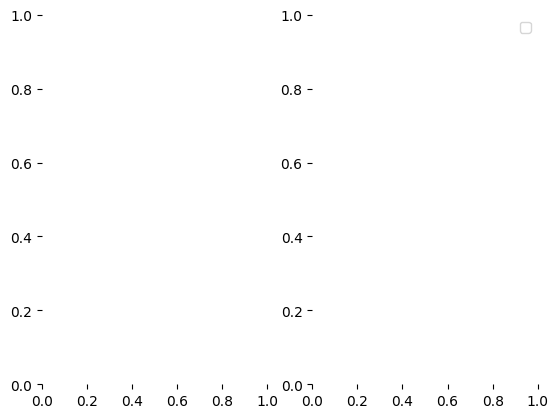

In [30]:
fig, (ax1,ax2) = plt.subplots(ncols=2,  subplot_kw=dict(frameon=False)) 

plt.subplots_adjust(hspace=.0)
plt.legend()

ax1.plot(X_test_res.index, X_test_res['pred_cumret_ind_fractional'], label = "Fractional with indicator", linestyle="-", color = 'red',alpha = 0.5)
ax1.plot(X_test_res.index, X_test_res['pred_cumret_base_fractional'], label = "Fractional without indicator", linestyle="--", color = 'blue', alpha = 0.5)
ax2.plot(X_test_res.index, X_test_res['pred_cumret_ind_positional'], label = "Positional with indicator", linestyle="-", color = 'red',alpha = 0.5)
ax2.plot(X_test_res.index, X_test_res['pred_cumret_base_positional'], label = "Positional without indicator", linestyle="--", color = 'blue', alpha = 0.5)
ax1.tick_params(labelrotation=90)
ax2.tick_params(labelrotation=90)
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')


plt.suptitle(f'{ticker_name} Equity Curve (Return) with {indicator_name}')
# plt.savefig(f'../imgs/{ticker_name}_{indicator_name}_curve')

average return 0.000151
[-4.06974377e-05  4.69218999e-05]
Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)
p_value:
0.0


Text(0.5, 1.0, 'White Reality Check with indicator')

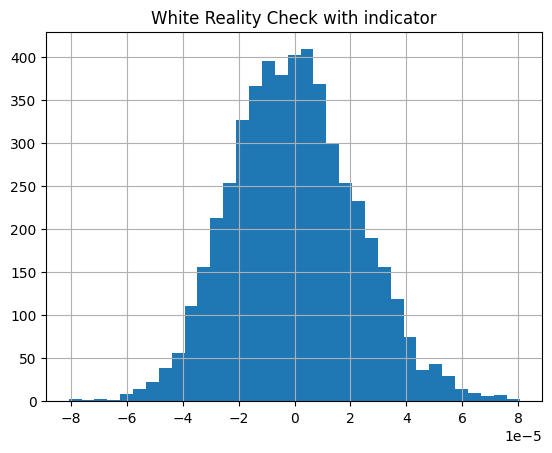

In [11]:
detrended_open = detrendPrice(X_test_res['true_open'] )
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(list(X_test_res['pred_ret'])).fillna(0)
bootstrap(detrended_syst_rets)
plt.title('White Reality Check with indicator')
# plt.savefig(f'../imgs/{ticker_name}_{indicator_name}_white_reality')

average return 0.000003
[-7.35737684e-06  7.86538968e-06]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.22099999999999997


Text(0.5, 1.0, 'White Reality Check without indicator')

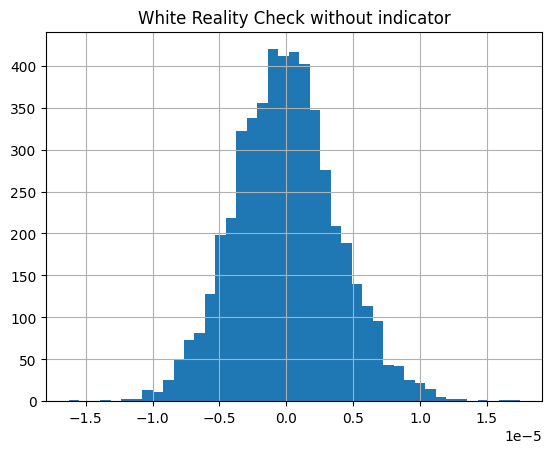

In [12]:
detrended_syst_rets = detrended_retFut1 * pd.Series(list(X_test_res['pred_ret_base'])).fillna(0)
bootstrap(detrended_syst_rets)
plt.title('White Reality Check without indicator')
# plt.savefig(f'../imgs/{ticker_name}_base_white_reality')

## This section is used to compare RSI models

We comment it for now because we do not run the model for RSI's in previous notebook.

In [ ]:
## this part is for comparing RSI's models, we comment it out for now

# rsi20_model = load(f'../model_joblib/{ticker_name}_{model_name}_RSI_20.joblib') 
# rsi25_model = load(f'../model_joblib/{ticker_name}_{model_name}_RSI_25.joblib') 
# rsi20ta_model = load(f'../model_joblib/{ticker_name}_{model_name}_RSI_20_ta.joblib') 
# rsi25ta_model = load(f'../model_joblib/{ticker_name}_{model_name}_RSI_25_ta.joblib') 

# X_test_ta = X_test.copy()

# X_test_ta['pred_ret_rsi20'] = rsi20_model.predict(X_test[base_col + ['RSI_20']])
# X_test_ta['pred_ret_rsi25'] = rsi25_model.predict(X_test[base_col + ['RSI_25']])
# X_test_ta['pred_ret_rsi20ta'] = rsi20ta_model.predict(X_test[base_col + ['RSI_20_ta']])
# X_test_ta['pred_ret_rsi25ta'] = rsi25ta_model.predict(X_test[base_col + ['RSI_25_ta']])
# X_test_ta['true_ret'] = y_test


# X_test_ta['pred_cumret_rsi20'] = np.cumprod( ((X_test_ta['pred_ret_rsi20'] * X_test_ta['true_ret']) ) + 1)  - 1
# X_test_ta['pred_cumret_rsi25'] = np.cumprod( ((X_test_ta['pred_ret_rsi25'] * X_test_ta['true_ret']) ) + 1)  - 1
# X_test_ta['pred_cumret_rsi20ta'] = np.cumprod( ((X_test_ta['pred_ret_rsi20ta'] * X_test_ta['true_ret']) ) + 1)  - 1
# X_test_ta['pred_cumret_rsi25ta'] = np.cumprod( ((X_test_ta['pred_ret_rsi25ta'] * X_test_ta['true_ret']) ) + 1)  - 1



In [ ]:
# import antropy as ant
# print(f'RSI 20 has antropy: ', ant.perm_entropy(X_test_ta['RSI_20'], normalize=True))
# print(f'RSI 25 has antropy: ', ant.perm_entropy(X_test_ta['RSI_25'], normalize=True))
# print(f'RSI talib 20 has antropy: ', ant.perm_entropy(X_test_ta['RSI_20_ta'], normalize=True))
# print(f'RSI talib 25 has antropy: ', ant.perm_entropy(X_test_ta['RSI_25_ta'], normalize=True))


In [ ]:
# plt.plot(X_test_ta.index, X_test_ta['pred_cumret_rsi20'], label = "Return curve RSI 20", linestyle="-", color = 'blue',alpha = 0.5)
# plt.plot(X_test_ta.index, X_test_ta['pred_cumret_rsi25'], label = "Return curve RSI 25", linestyle="-", color = 'purple', alpha = 0.5)
# plt.plot(X_test_ta.index, X_test_ta['pred_cumret_rsi20ta'], label = "Return curve RSI 20 Talib", linestyle="-", color = 'red',alpha = 0.5)
# plt.plot(X_test_ta.index, X_test_ta['pred_cumret_rsi25ta'], label = "Return curve RSI 25 Talib", linestyle="-", color = 'orange', alpha = 0.5)
# plt.xticks(rotation=90)
# plt.legend()
# plt.suptitle(f'{ticker_name} Equity Curve (Return) Comparison Over RSI')
# # plt.savefig(f'../imgs/{ticker_name}_RSI_curve')

In [ ]:
# dt_peak_analysis = X_test_ta[ (X_test_ta.index > '2020-03-01') & (X_test_ta.index < '2020-05-01') ]
# dt_peak_analysis['retFut1'] = y_test
# dt_peak_analysis['retFut1_diff'] = dt_peak_analysis['retFut1'].diff()
# color_dict = {
#     'Open':'pink',
#     'retFut1':'black',
#     'retFut1_diff':'grey',
#     'pred_cumret_rsi20':'blue',
#     'pred_cumret_rsi25':'purple',
#     'pred_cumret_rsi20ta':'red',
#     'pred_cumret_rsi25ta':'orange'
# }

# name_dict = {
#     'Open':'Price',
#     'retFut1':'Future Return',
#     'retFut1_diff':'Future Return diff',
#     'pred_cumret_rsi20':'Cumulative_return_RSI20',
#     'pred_cumret_rsi25':'Cumulative_return_RSI25',
#     'pred_cumret_rsi20ta':'Cumulative_return_RSI20_talib',
#     'pred_cumret_rsi25ta':'Cumulative_return_RSI25_talib'
# }

In [ ]:


# col_names = ['Open','retFut1','retFut1_diff','pred_cumret_rsi20','pred_cumret_rsi25','pred_cumret_rsi20ta','pred_cumret_rsi25ta']

# fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 10), sharex=True,)
# plt.subplots_adjust(hspace=0.5)
# plt.xticks(rotation=90)
# for idx, colname in enumerate(col_names):
#     axes[idx].plot(dt_peak_analysis.index, dt_peak_analysis[colname], label = colname, linestyle="-", color = color_dict[colname],alpha = 0.5)
#     axes[idx].title.set_text(name_dict[colname])
#     axes[idx].axvline(datetime.datetime(2020, 3, 11), alpha = 0.8)
#     axes[idx].axvline(datetime.datetime(2020, 3, 20), alpha = 0.2)
#     axes[idx].axvline(datetime.datetime(2020, 3, 31), alpha = 0.2)
#     axes[idx].axvline(datetime.datetime(2020, 4, 7), alpha = 0.2)
# plt.savefig(f'../imgs/{ticker_name}_peak_analysis')